In [1]:
import mplfinance as mpf
import pandas as pd
from pathlib import Path
import numpy as np
import datetime

In [2]:
# Get BTC OHLCV dataframe
df = pd.read_csv(Path("./Resources/BTC-5YRS-D.csv"), index_col="Date", parse_dates=True, infer_datetime_format=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
# Slice of double bottom
intra = df.dropna()

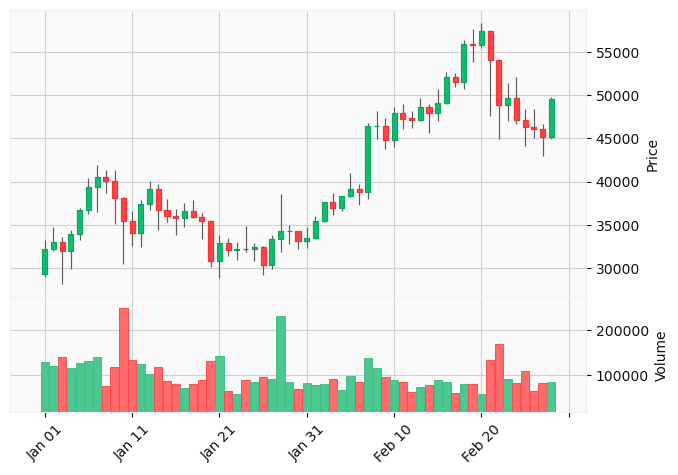

In [44]:
mpf.plot(intra['2021-01':'2021-02'], type="candle", style="yahoo", volume=True)

In [5]:
# Check if there is a previous bar
def update_cert(cert, index, df):
    """
    Create certifying candle
    count number of null values to see if is first row
    """
    null_count = 0
    for value in cert.values():
        if value == None:
            null_count += 1
    
    # update prev dictionary if all null values
    # if first row it will update with those values
    if null_count == 5:
        cert['t'] = index
        cert['o'] = float(df.loc[index]['Open'])
        cert['c'] = float(df.loc[index]['Close'])
        cert['h'] = float(df.loc[index]['High'])
        cert['l'] = float(df.loc[index]['Low'])
        
        # return the certying candle dictionary
        return cert
    
    # update prev with new prev values (new prev is old curr)
    else:
        if index + datetime.timedelta(days=1):
            cert['t'] = (index)
            cert['o'] = float(df.loc[index]['Open'])
            cert['c'] = float(df.loc[index]['Close'])
            cert['h'] = float(df.loc[index]['High'])
            cert['l'] = float(df.loc[index]['Low'])
        
            # return the certying candle dictionary
            return cert
        
def update_curr(curr, index, df):
    """Create current dictionary of current candle"""
    idx = df.index  
    
    # format datetime index
    dt_object = (index - datetime.timedelta(days=1)).to_datetime64()
    
    if sum(df.index == dt_object) > 0:
        index -= datetime.timedelta(days=1)
        curr['t'] = (index)
        curr['o'] = float(df.loc[index]['Open'])
        curr['c'] = float(df.loc[index]['Close'])
        curr['h'] = float(df.loc[index]['High'])
        curr['l'] = float(df.loc[index]['Low'])
        
        # return the current candle dictionary
        return curr
    else:
        pass
        
def update_prev(prev, index, df):
    """Create the previous candle"""
    idx = df.index
    

    dt_object = (index - datetime.timedelta(days=2)).to_datetime64()

    if sum(df.index == dt_object) > 0:
        index -= datetime.timedelta(days=2)
        prev['t'] = (index)
        prev['o'] = float(df.loc[index]['Open'])
        prev['c'] = float(df.loc[index]['Close'])
        prev['h'] = float(df.loc[index]['High'])
        prev['l'] = float(df.loc[index]['Low'])
        
        # return the previous candle dictionary
        return prev
    else:
        pass

In [6]:
def find_max(cert_candle, curr_candle, prev_candle):
    """get local max"""
    max_dict = {}
    if curr_candle and prev_candle:       
        if (curr_candle['c'] > cert_candle['c']) & (curr_candle['c'] > prev_candle['c']):
            max_dict = curr_candle
            return max_dict
        else:
            return None
        
def find_min(cert_candle, curr_candle, prev_candle):   
    """get local min"""
    min_dict = {}
    if curr_candle and prev_candle:
        if (curr_candle['c'] < cert_candle['c']) & (curr_candle['c'] < prev_candle['c']):
            min_dict = curr_candle
            return min_dict
        else:
            return None

In [7]:
def create_dataframe(df):
    """
    Create DataFrame with local minimums and maximums to create signals for double bottom creation
    Accepts DataFrames with columns formatted as 'Open', 'Close', 'High', 'Low'.
    More columns can be added.
    """
    
    # store previous candle
    prev = {
        't' : None,
        'o' : None,
        'c' : None,
        'h' : None,
        'l' : None   
    }

    # store current candle
    curr = {
        't' : None,
        'o' : None,
        'c' : None,
        'h' : None,
        'l' : None 
    }

    # store certifying candle (certifies if the max/min is created)
    cert = {
        't' : None,
        'o' : None,
        'c' : None,
        'h' : None,
        'l' : None 
    }

    # Init lists for max and min events
    max_ = []
    min_ = []

    # Iterrate through dataframes indexes
    for index in df.index:
        cert_candle = update_cert(cert, index, df)
        curr_candle = update_curr(curr, index, df)
        prev_candle = update_prev(prev, index, df)

        # pont f arbitrary - 5 periods out
        # when finished will have 6 values
        mx = find_max(cert_candle, curr_candle, prev_candle)
        mn = find_min(cert_candle, curr_candle, prev_candle)

        # max stores close and high
        # min stores close and low
        if mx == None:
            max_.append(0)
        else:
            max_.append(1)

        if mn == None:
            min_.append(0)      
        else:
            min_.append(1)

    # Adding min/max events to original dataframe then creating a copy with columns for double bottom events
    max_min_df = pd.DataFrame({'Max': max_, 'Min': min_})
    max_min_df = max_min_df[['Max', 'Min']].shift(-1)
    max_min_df['Date'] = df.index
    max_min_df.set_index('Date', inplace=True)
    df_features = pd.concat([df, max_min_df], axis=1)
    df_features[['A', 'B', 'C', 'D', 'E', 'F', 'DB']] = 0.0
    
    return df_features

In [8]:
display(create_dataframe(intra).head())
new_df = create_dataframe(intra)

,Open,Low,High,Close,Volume,Max,Min,A,B,C,D,E,F,DB
Date,,,,,,,,,,,,,,
2017-08-16,4261.48,4200.74,4485.39,4285.08,795.150377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,4285.08,3938.77,4371.52,4108.37,1199.888264,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,4108.37,3850.00,4184.69,4139.98,381.309763,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,4120.98,4032.62,4211.08,4086.29,467.083022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,4069.13,3911.79,4119.62,4016.00,691.743060,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def get_events(new_df):
    """Returns dataframe with binary encoded events"""
    
    # Init return variables
    events_list = [None, None, None, None, None]
    search_c = {}
    total_occurrences = 0
    occurrences = {}
    
    # Init helper variables
    buy = None
    sell = None
    sales = []
    buys = []
    maxs = []
    mins = []
    
    for index in new_df.index:
        # Store all local max indexes
        if new_df.loc[index, 'Max'] == 1:
            maxs.append(index)
            
        # Store all local min indexes
        if new_df.loc[index, 'Min'] == 1:
            mins.append(index)
            
        # Start search for A if A is none
        if events_list[0] == None:
            if new_df.loc[index, 'Max'] == 1:
                events_list[0] = index
                new_df.loc[index, 'A'] = 1
                
            elif new_df.loc[index, 'Max'] != 1:
                new_df.loc[index, 'A'] == 0
                
        # Show that A exists
        elif events_list[0] != None:
            new_df.loc[index, 'A'] = 1
            
        # Reset if does not exist
        else:
            new_df.loc[index, 'A'] = 0
            
        # Start search for B if B is none
        if (events_list[1] == None) & (events_list[0] != None):
            if new_df.loc[index, 'Min'] == 1:
                if new_df.loc[index, 'Close'] < new_df.loc[events_list[0], 'Close']:
                    events_list[1] = index
                    new_df.loc[index, 'B'] = 1
                
                else:
                    new_df.loc[index, 'B'] = 0
                    
        # Show that B exists
        elif events_list[1] != None:
            new_df.loc[index, 'B'] = 1
            
        # Reset if does not exist    
        else:
            new_df.loc[index, 'B'] = 0

        # Start search for C
        if (events_list[2] == None) & (events_list[1] != None) & (events_list[0] != None):
            
            if new_df.loc[index, 'Max'] == 1:
                
                # Establish conditions
                condition_1 = (new_df.loc[index, 'Close'] > new_df.loc[events_list[1], 'Close'])
                condition_2 = (new_df.loc[index, 'Close'] < new_df.loc[events_list[0], 'Close'])
                
                # if C is in range between B and A
                if condition_1 & condition_2:
                    
                    events_list[2] = index
                    new_df.loc[index, 'C'] = 1
                    
                # if C is higher than A
                elif new_df.loc[index, 'Close'] > new_df.loc[events_list[0], 'Close']:
                    
                    new_df.loc[index, 'C'] = 0
                    new_df.loc[index, 'B'] = 0
                    events_list = [None, None, None, None, None]
                    
        # Show if C exists
        elif events_list[2] != None:
            new_df.loc[index, 'C'] = 1
            
        # Reset if does not exist   
        else:
            new_df.loc[index, 'C'] = 0
            
        # Start search for D
        if (events_list[3] == None) & (events_list[2] != None) & (events_list[1] != None) & (events_list[0] != None):
            
            if new_df.loc[index, 'Min'] == 1:   
                
                # Establish conditions
                condition_1 = (new_df.loc[index, 'Close'] < new_df.loc[events_list[1], 'Close'])
                condition_2 = (new_df.loc[index, 'Close'] > new_df.loc[events_list[1], 'Low'])
                condition_3 = (new_df.loc[index, 'Low'] < new_df.loc[events_list[1], 'Close'])
                condition_4 = (new_df.loc[index, 'Low'] > new_df.loc[events_list[1], 'Low'])
                
                # Exit conditions
                e_cond = (new_df.loc[index, 'Close'] < new_df.loc[events_list[1], 'Low'])
                e_cond_2 = (new_df.loc[index, 'Low'] < new_df.loc[events_list[1], 'Low'])
                
                # if D is in the range of B's low and close
                if condition_1 & condition_2 | condition_3 & condition_4:
                    
                    events_list[3] = index
                    new_df.loc[index, 'D'] = 1
                    
                    # Search between B and D for highest max
                    for index in new_df.loc[events_list[1]:events_list[3]].index:
                        
                        if new_df.loc[index, 'Max'] == 1:
                            search_c[index] = new_df.loc[index, 'Close']

                    # find max c value and add it to the events list
                    max_c = max(search_c, key = lambda x: search_c[x])
                    events_list[2] = max_c
                    max_c = max_c.to_datetime64()
                    new_df.loc[max_c, 'C'] = 1

                # If close is greater than C and greater than A
                elif (new_df.loc[index, 'Close'] > new_df.loc[events_list[2], 'Close']) & (new_df.loc[index, 'Close'] > new_df.loc[events_list[0], 'Close']):
                    
                    if new_df.loc[index, 'Max'] == 1:
                        events_list = [index, None, None, None, None]
                        search_c = {}
                        
                    elif new_df.loc[index, 'Min'] == 1:
                        events_list = [maxs[-1], index, None, None, None]
                        search_c = {}
                
                # if D is less than B's low
                elif e_cond:
                    
                    if new_df.loc[index, 'Min'] == 1:
                        events_list = [maxs[-1], index, None, None, None]
                        search_c = {}
                        
                    elif new_df.loc[index, 'Max'] == 1:
                        events_list = [index, None, None, None, None]
                        search_c = {}
                        
                    else:
                        events_list = [maxs[-1], None, None, None, None]
                        search_c = {}
                    
        # Show if D exists
        elif events_list[3] != None:
            new_df.loc[index, 'D'] = 1
        
        # Reset if does not exist
        else:
            new_df.loc[index, 'D'] = 0
            
        # start search E trade (entry)
        if (events_list[4] == None) & (events_list[3] != None) & (events_list[2] != None) & (events_list[1] != None) & (events_list[0] != None):
            if new_df.loc[index, 'Close'] > new_df.loc[events_list[2], 'Close']:
                events_list[4] = index
                new_df.loc[index, 'E'] = 1
                new_df.loc[index, 'DB'] = 1
                occurrences[total_occurrences] = events_list
                total_occurrences += 1
                
                if events_list[4] != None:
                    events_list = [None, None, None, None, None]
                    

                
            # restart if close below D
            elif new_df.loc[index, 'Close'] < new_df.loc[events_list[3], 'Low']:
                new_a = events_list[2]
                events_list = [new_a, None, None, None, None]
                search_c = {}
                
        # Set buy date
        if new_df.loc[index, 'DB'] == 1:
            buy = index
            sell = (index + datetime.timedelta(days=5)).to_datetime64()
            sales.append(sell)
            buys.append(buy)
            events_list = [None, None, None, None, None]
            
        # Create sell events
        if sum(new_df.index == sell) > 0:
            new_df.loc[buy, 'F'] = 0
            new_df.loc[sell, 'F'] = float(new_df.loc[sell, 'Close'] - new_df.loc[buy, 'Close'])
#             new_df.loc[sell]['DB'] = -1                      
        
    return new_df, total_occurrences, occurrences, sales

In [10]:
# Store outputs of function
new_df, total_occurrences, occurrences, sales = get_events(new_df)

In [11]:
# pd.set_option('display.max_rows', None)
# display(new_df.head(50))

In [12]:
nn_2 = (new_df.loc[new_df['DB'] == 1]).copy()

nn_2 [['Leadup', 'AB_Days', 'AB_Vert', 'AB', 'BC_Days', 'BC_Vert', 'BC', 'CD_Days', 'CD_Vert', 'CD', 'DE_Vert', 'DE_Days', 'DE', 'EF']] = 0.0

In [13]:
ab = 0.0
bc = 0.0
cd = 0.0
de = 0.0
ef = 0.0

for k, v in occurrences.items():

    # Get event points
    a = v[0]
    b = v[1]
    c = v[2]
    d = v[3]
    e = v[4]
    
    # Get length of days between points
    ab = (b-a).days
    bc = (c-b).days
    cd = (d-c).days
    de = (e-d).days
    
    # Find f index
    f = e + datetime.timedelta(days=5)
    
    # Get prices
    ab_range = new_df.loc[b]['Close'] - new_df.loc[a]['Close']
    bc_range = new_df.loc[c]['Close'] - new_df.loc[b]['Close']
    cd_range = new_df.loc[d]['Close'] - new_df.loc[c]['Close']
    de_range = new_df.loc[e]['Close'] - new_df.loc[d]['Close']
    
    # Get ef output
    ef_range = new_df.loc[f]['Close'] - new_df.loc[e]['Close']
    
    # Get slope
    ab_slope = (ab_range / ab)
    bc_slope = (bc_range / bc)
    cd_slope = (cd_range / cd)
    de_slope = (de_range / de)
    
    # Get leadup index
    leadup = a - datetime.timedelta(days=2)
    
    
    # Set day values
    nn_2.loc[e]['AB_Days'] = ab
    nn_2.loc[e]['BC_Days'] = bc
    nn_2.loc[e]['CD_Days'] = cd
    nn_2.loc[e]['DE_Days'] = de
    
    # Set vert range value
    nn_2.loc[e]['AB_Vert'] = ab_range
    nn_2.loc[e]['BC_Vert'] = bc_range
    nn_2.loc[e]['CD_Vert'] = cd_range
    nn_2.loc[e]['DE_Vert'] = de_range
    
    # Set values of slopes 
    nn_2.loc[e]['AB'] = ab_slope
    nn_2.loc[e]['BC'] = bc_slope
    nn_2.loc[e]['CD'] = cd_slope
    nn_2.loc[e]['DE'] = de_slope
    nn_2.loc[e]['EF'] = ef_range
    
    # Set values of slopes 
    nn_2.loc[e]['A'] = new_df.loc[a]['Close']
    nn_2.loc[e]['B'] = new_df.loc[b]['Close']
    nn_2.loc[e]['C'] = new_df.loc[c]['Close']
    nn_2.loc[e]['D'] = new_df.loc[d]['Close']
    nn_2.loc[e]['E'] = new_df.loc[e]['Close']
    nn_2.loc[e]['F'] = new_df.loc[f]['Close']
    
    # Set leadup
    nn_2.loc[e]['Leadup'] = new_df.loc[leadup]['Close']
    

nn_2

,Open,Low,High,Close,Volume,Max,Min,A,B,C,...,BC_Days,BC_Vert,BC,CD_Days,CD_Vert,CD,DE_Vert,DE_Days,DE,EF
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-24,8138.99,8090.00,8734.78,8700.01,4292.623682,0.0,0.0,8212.00,8119.51,8205.92,...,1.0,86.41,86.410000,1.0,-185.93,-185.930000,680.02,2.0,340.010000,1138.95
2018-04-01,6813.01,6765.00,7125.00,7056.00,32123.560072,0.0,0.0,7949.30,6840.23,6923.91,...,1.0,83.68,83.680000,1.0,-110.90,-110.900000,242.99,1.0,242.990000,-160.20
2018-08-16,6316.00,6285.40,6585.00,6584.49,57851.610803,1.0,0.0,7024.19,6285.00,6529.79,...,1.0,244.79,244.790000,1.0,-385.78,-385.780000,440.48,7.0,62.925714,-223.60
2018-10-04,6591.69,6543.08,6697.00,6635.65,16096.552392,1.0,0.0,6689.13,6596.38,6626.57,...,1.0,30.19,30.190000,3.0,-116.57,-38.856667,125.65,2.0,62.825000,-4.65
2019-02-07,3398.40,3373.10,3733.58,3659.04,47968.058013,0.0,0.0,3569.62,3411.04,3504.77,...,4.0,93.73,23.432500,5.0,-106.37,-21.274000,260.64,1.0,260.640000,-49.64
2019-03-04,3716.10,3703.55,3877.10,3857.73,32962.536162,0.0,0.0,4117.76,3743.56,3827.92,...,1.0,84.36,84.360000,7.0,-112.62,-16.088571,142.43,1.0,142.430000,59.09
2019-03-26,3948.77,3936.15,4048.00,4038.05,32364.555852,1.0,0.0,4043.04,3980.64,4006.01,...,2.0,25.37,12.685000,2.0,-69.89,-34.945000,101.93,2.0,50.965000,106.51
2019-07-29,9509.07,9402.00,9714.28,9574.21,32536.368834,0.0,0.0,9879.87,9476.52,9541.54,...,1.0,65.02,65.020000,1.0,-33.90,-33.900000,66.57,1.0,66.570000,1355.02
2019-08-18,10306.17,10258.60,10930.00,10915.54,37243.319217,1.0,0.0,11549.97,10050.37,10331.54,...,2.0,281.17,140.585000,1.0,-115.52,-115.520000,699.52,2.0,349.760000,-781.19


In [14]:
nn_2.to_csv(Path('./Resources/21_features.csv'))

In [15]:
occurrences

{0: [Timestamp('2017-11-19 00:00:00'),
  Timestamp('2017-11-20 00:00:00'),
  Timestamp('2017-11-21 00:00:00'),
  Timestamp('2017-11-22 00:00:00'),
  Timestamp('2017-11-24 00:00:00')],
 1: [Timestamp('2018-03-27 00:00:00'),
  Timestamp('2018-03-29 00:00:00'),
  Timestamp('2018-03-30 00:00:00'),
  Timestamp('2018-03-31 00:00:00'),
  Timestamp('2018-04-01 00:00:00')],
 2: [Timestamp('2018-08-04 00:00:00'),
  Timestamp('2018-08-07 00:00:00'),
  Timestamp('2018-08-08 00:00:00'),
  Timestamp('2018-08-09 00:00:00'),
  Timestamp('2018-08-16 00:00:00')],
 3: [Timestamp('2018-09-26 00:00:00'),
  Timestamp('2018-09-28 00:00:00'),
  Timestamp('2018-09-29 00:00:00'),
  Timestamp('2018-10-02 00:00:00'),
  Timestamp('2018-10-04 00:00:00')],
 4: [Timestamp('2019-01-23 00:00:00'),
  Timestamp('2019-01-28 00:00:00'),
  Timestamp('2019-02-01 00:00:00'),
  Timestamp('2019-02-06 00:00:00'),
  Timestamp('2019-02-07 00:00:00')],
 5: [Timestamp('2019-02-22 00:00:00'),
  Timestamp('2019-02-23 00:00:00'),
  Tim

In [16]:
total_occurrences

21

In [18]:
for k, v in occurrences.items():
    print(v[0])

2017-11-19 00:00:00
2018-03-27 00:00:00
2018-08-04 00:00:00
2018-09-26 00:00:00
2019-01-23 00:00:00
2019-02-22 00:00:00
2019-03-19 00:00:00
2019-07-24 00:00:00
2019-08-10 00:00:00
2019-09-11 00:00:00
2019-10-28 00:00:00
2019-11-01 00:00:00
2020-01-20 00:00:00
2020-03-10 00:00:00
2020-04-07 00:00:00
2020-07-31 00:00:00
2020-08-05 00:00:00
2020-08-31 00:00:00
2021-01-17 00:00:00
2021-02-20 00:00:00
2021-06-19 00:00:00


In [42]:
for k, v in occurrences.items():
    a = v[0]
    f = (v[4] + datetime.timedelta(days=5))
    
    a = a.strftime("%Y-%m-%d")
    f = f.strftime("%Y-%m-%d")
    
#     print(a, f)
    mpf.plot(new_df.loc[str(a):str(f)], type="candle", style="yahoo", volume=True, savefig=Path(f'./Resources/event_figures/event_{k}.png'))

In [ ]:
total = 0

for sale in sales:   
    total += new_df.loc[sale, 'F']
    
print(total*shares)

In [ ]:
# event_list_shannon = []
# def create_list_of_event_points_to_add_to_event_dictionar(date_range_dataframe):
#     for i in date_range_dataframe check if this date's prices' make up local max
#         if yes, store to list labeled event %(+1) = ['a']
#         (assign position of a list to a variable)
#         check event1_list; if [0] is not null then check if this date's prices' make up a local min and assign value b
#         check event1_list; if [1] is not null then check if this date's prices' make up a local max and assign value c; c should be lower than a but higher than b; if conditions are not met, clear event list and start new list iteration on next date
#         check event1_list; if [2] is not null then check if this date's prices' make up a local min and assign value d; if this is min then continue to [check for b conditions]  if local min close is in range of b (between b close and b low) then local min event point d or if local min d low is in range of b close and b low then local min is event point d, elif close d is below b low then delete list and start next date     
#         check event1_list; if [3] is not null then check if this date's prices'are higher than event point c and assign value e
#         check event1_list; if [4] is not null then find price 5 days after point e and label this +5 day price point f
#         check event1_list; if [5] is not null then find price 5 days before point a and label this as the"lead up" event point